In [1]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.special as special

## Frequency characteristic

Taken majorly from [Brain wave characteristic](http://www.brainev.com/core/Research-Benefits/Brainwaves.aspx)

### Beta
* Beta activity is quick-connect, fast activity and tends to dominate the normal waking state of consciousness when-attention is directed towards the outside world. 
* detected in the frontal lobes (where decisions are managed)
* Both sides of the brain
* tends to be the dominant rhythm in those who are alert, anxious or have their eyes open.

### Alpha
* represent a relaxed awareness in the mind
* Alpha rates are increased by closing the eyes and relaxing, yet are offset by opening one's eyes or any concentrated effort
* best detected in the frontal regions of the head, on each side of the brain.
* Alpha is the major rhythm seen in normal relaxed adults and is typically regarded as the common relaxation mode beyond the age of 13

### Theta
* indicate drowsiness, daydreaming, the first stage of sleep or 'indirect' imagination/thinking
* Theta activity is not often seen in awake adults (unless engaged in a meditative practice), but is perfectly normal in alert children up to 13 years and in most sleep
* Theta state can be regarded as a gateway to hypnagogic states that lay between being awake and falling asleep
* 

### Delta

* deep sleep or slow-wave 'background' thinking
* tends to be the highest in amplitude and the slowest waves. Delta is often associated with deep sleep. Certain frequencies, in the delta range, have been shown to trigger the body's healing and growth mechanisms.
* Delta is the dominant rhythm in infants up to one year, as well as stages 3 and 4 of dreamless sleep.

## Creating the dataset

In [2]:
freq_ranges = [[1.5, 3.5],  # delta Unconscious, deep sleep
               [3.5, 7.5],  # theta Reduced consciousnenss
               [7.5, 12.5],  # alpha Physical and mental relaxation
               [12.5, 19.5]]  # beta Engaged mind
            
#freq_ranges = [[1.5, 3.5]]

sample_rate = 50              
duration_of_segment = 10 #(in seconds)
num_segments = len(freq_ranges)

Time = np.linspace(0,  duration_of_segment * num_segments, num_segments * duration_of_segment * sample_rate)

sliding_window_size = 50

frequencies = []
for freq in freq_ranges:
    frequencies.append(np.random.uniform(freq[0], freq[1]))
    
frequencies = np.array(frequencies)
rad_frequencies = 2*np.pi*frequencies
    
stds = [1, 2, 5, 7]
#stds = [1, 1, 1, 1]

In [3]:
TS = []
for i, freq in enumerate(frequencies):
    std = stds[i:]+stds[:i]
    rvals = np.random.normal(0, 0.5, num_segments)
    
    #rvals = np.ones(4)
    
    start = i*duration_of_segment * sample_rate 
    
    time = Time[start : start + duration_of_segment * sample_rate]
    #print(time.shape)
    
    delta = np.random.normal(0, std[0], time.shape[0]) * rvals[0]
    theta = np.random.normal(0, std[1], time.shape[0]) * rvals[1]
    alpha = np.random.normal(0, std[3], time.shape[0]) * rvals[2]
    beta = np.random.normal(0, std[2], time.shape[0]) * rvals[3]
    
    
    #delta = theta = alpha = beta = np.ones((time.shape[0]))
    
    delta_signal = delta * np.cos(rad_frequencies[0] * time) + delta * np.sin(rad_frequencies[0] * time)
    theta_signal = theta * np.cos(rad_frequencies[1] * time) + theta * np.sin(rad_frequencies[1] * time)
    alpha_signal = alpha * np.cos(rad_frequencies[2] * time) + alpha * np.sin(rad_frequencies[2] * time)
    beta_signal = beta * np.cos(rad_frequencies[3] * time) + beta * np.sin(rad_frequencies[3] * time)
    
    delta_signal = alpha_signal = beta_signal = np.zeros(delta_signal.shape[0])
    
    TS = np.hstack((TS, delta_signal + theta_signal + alpha_signal + beta_signal))

In [4]:
np.savetxt('ts.csv', TS)

In [5]:
plt.close()

In [6]:
Time.shape

(2000,)

<IPython.core.display.Javascript object>


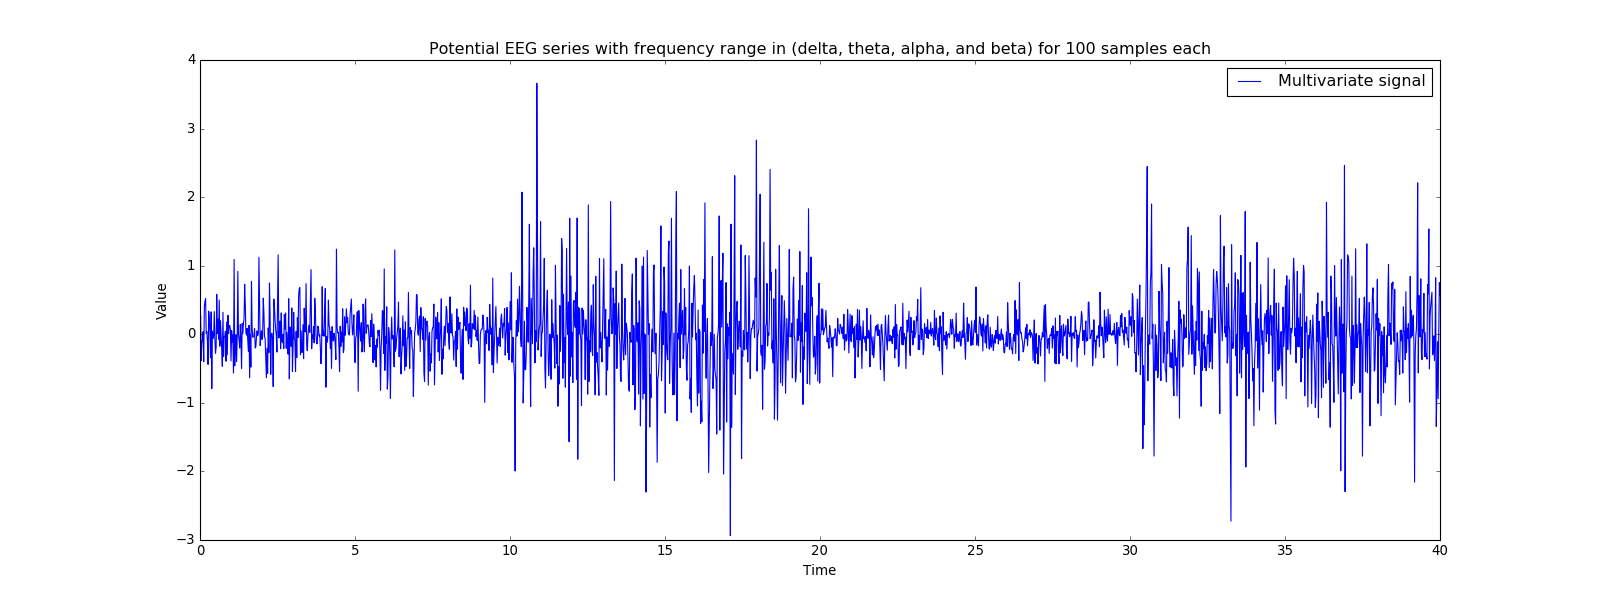

In [7]:
plt.figure(figsize=(20,7.5))
plt.plot(Time, TS, label="Multivariate signal")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Potential EEG series with frequency range in (delta, theta, alpha, and beta) for 100 samples each")
plt.legend()
plt.savefig('../reports/images/changepoint_sd/ts.png')

In [8]:
plt.close()

In [19]:
print(TS.std(), TS.mean())

2.15963865211 -0.0669448093127


In [20]:
Time

array([  0.00000000e+00,   2.00100050e-02,   4.00200100e-02, ...,
         3.99599800e+01,   3.99799900e+01,   4.00000000e+01])

## Peridogram

In [57]:
def get_peridogram(u, segment, segment_times):
    abs_val = np.absolute(np.sum(segment * np.power(np.e, 1J*u*segment_times)))
    return ((1/(2*np.pi*segment.shape[0])) * np.power(abs_val, 2))

In [58]:
peridograms = []

for l in np.linspace(0, np.pi, 200):
    peridograms.append(get_peridogram(l, TS, Time))
    
peridograms = np.array(peridograms)

<IPython.core.display.Javascript object>


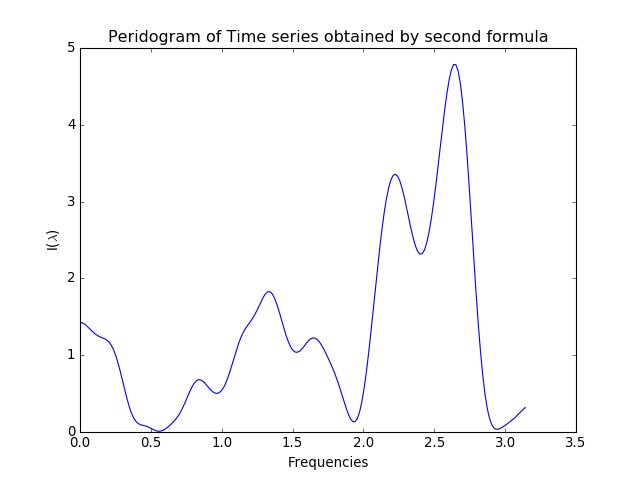

[  2.66044188   4.37829936   7.6099658   13.85750305]
[ 16.7160493   27.5096662   47.81482528  87.06925957]
[ 0.69093547  1.00808604  2.24625792  2.37692497]
[ 1.2367067   1.29113244  1.32678049  2.66044188]


In [85]:
plt.title("Peridogram of Time series obtained by second formula")
plt.plot(np.linspace(0, np.pi, 200), peridograms, label='Peridogram')
plt.xlabel("Frequencies")
plt.ylabel("I($\lambda$)")
plt.savefig('../reports/images/changepoint_sd/peri2.png')

print(frequencies)
print(rad_frequencies)
print(np.sort(rad_frequencies % np.pi))
print(np.sort(frequencies % np.pi))

In [61]:
plt.close()

In [62]:
(peridograms.max()*50)/(2*np.pi)

38.078479560913614

In [63]:
frequencies

array([  2.66044188,   4.37829936,   7.6099658 ,  13.85750305])

In [64]:
rad_frequencies

array([ 16.7160493 ,  27.5096662 ,  47.81482528,  87.06925957])

In [65]:
step_size = 5 #seconds
segment_samples = sample_rate * step_size
print(segment_samples)

def f_k_j(k, ts, time_range):
    return integrate.quad(get_peridogram, 0, np.pi, args=(ts[k:k+segment_samples], time_range[k:k+segment_samples]))

250


In [66]:
def J(total_samples, k):
    return (-1/total_samples) * segment_samples * np.power(f_k_j(k, TS, Time), 2)


list_of_js = []
for k in np.arange(0, TS.shape[0], step_size):
    list_of_js.append(J(TS.shape[0], k))
    
list_of_js = np.array(list_of_js)

In [67]:
js = np.array(list_of_js)

In [77]:
plt.close()

<IPython.core.display.Javascript object>


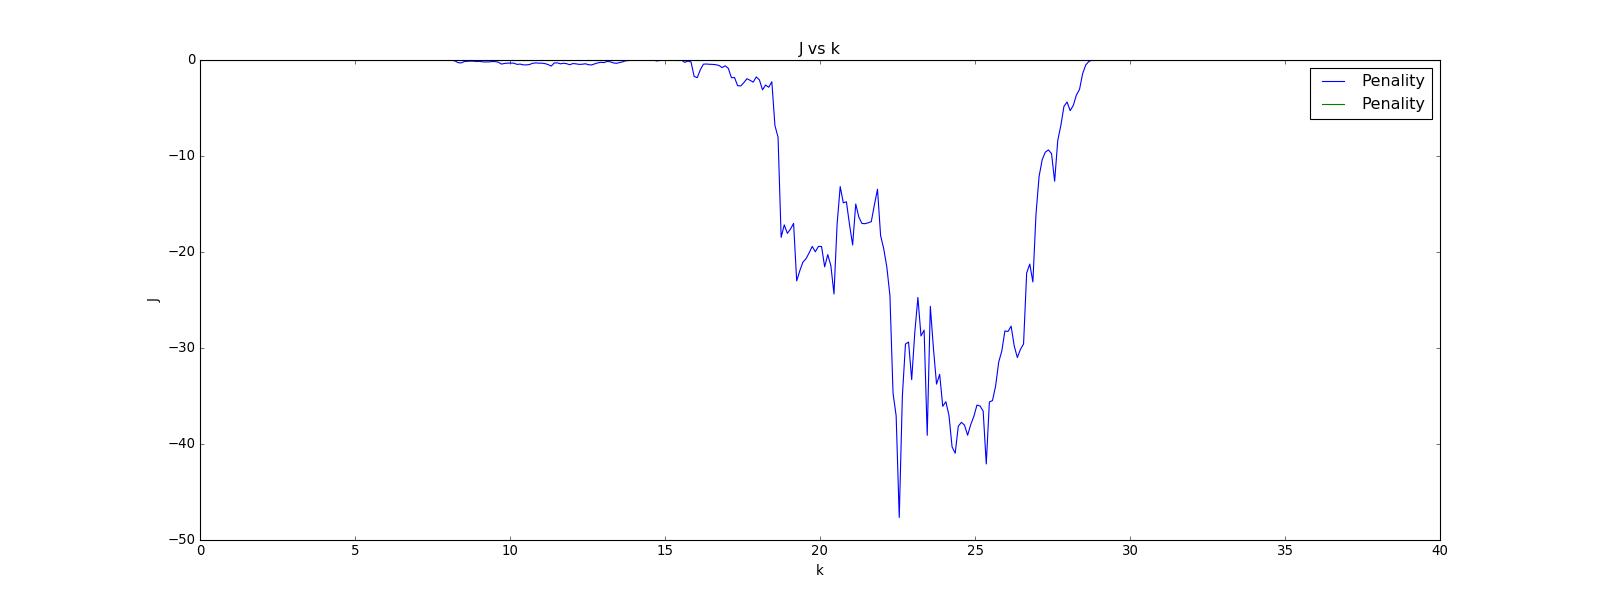

In [83]:
plt.figure(figsize=(20,7.5))
plt.title("J vs k")
plt.xlabel("k")
plt.ylabel("J")
plt.plot(np.linspace(0, 40, 400), js, label="Penality")
plt.legend()
plt.savefig("../reports/images/changepoint_sd/penality.png")

In [84]:
plt.close()